In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font', family = 'Malgun Gothic')
import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [2]:
df = pd.read_excel('../data/20230818/수출신고지검사결과.xlsx',engine='openpyxl')

In [3]:
df.head(3)

,수출신고번호,품명,거래품명,검사일자,수출신고세관부호,수출신고과코드,수출검사결과코드,수출검사결과조치코드,검사조치내역
0,1058618002129X,RED PEPPER POWDER WITH SEED,RED PEPPER POWDER,20180822,12,10,L,C,분석의뢰
1,1286918201786R,OTHER PLASTICS ROD,POLY ETHER ETHER KETON ROD,20181226,20,15,M1,F,서류 정정 후 통관
2,1286918201786R,OTHER PLASTICS PLATE,POLY ETHER ETHER KETON PLATE,20181226,20,15,M1,F,서류 정정 후 통관


In [4]:
# Z항목만 추출
ddf = df[df['수출검사결과코드']=='Z'].copy()

In [5]:
ddf.head(3)

,수출신고번호,품명,거래품명,검사일자,수출신고세관부호,수출신고과코드,수출검사결과코드,수출검사결과조치코드,검사조치내역
11,4293418103859X,OTHER GI PIPE,GI PIPE,20180911,30,82,Z,B,운송용기 정정
12,2150318102356X,ETHYLENE-ALPHA-OLEFIN COPOLYMERS,POLYOLEFIN ELASTOMER,20181005,30,82,Z,B,적재예정보세구역 정정
13,2150318102356X,ETHYLENE-ALPHA-OLEFIN COPOLYMERS,RESIN INFUSE,20181005,30,82,Z,B,적재예정보세구역 정정


In [6]:
ddf['검사조치내역'] = ddf['검사조치내역'].fillna('')

In [7]:
ddf['total_text'] = ddf['검사조치내역'] 

In [8]:
# df['total_text'] = df['total_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","")
ddf['total_text'] = ddf['total_text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]","", regex=True)
ddf['total_text'] = ddf['total_text'].str.replace("ㅇ","", regex=True)

In [9]:
# 결측행 삭제
ddf.dropna(axis=0)

,수출신고번호,품명,거래품명,검사일자,수출신고세관부호,수출신고과코드,수출검사결과코드,수출검사결과조치코드,검사조치내역,total_text
11,4293418103859X,OTHER GI PIPE,GI PIPE,20180911,30,82,Z,B,운송용기 정정,운송용기 정정
12,2150318102356X,ETHYLENE-ALPHA-OLEFIN COPOLYMERS,POLYOLEFIN ELASTOMER,20181005,30,82,Z,B,적재예정보세구역 정정,적재예정보세구역 정정
13,2150318102356X,ETHYLENE-ALPHA-OLEFIN COPOLYMERS,RESIN INFUSE,20181005,30,82,Z,B,적재예정보세구역 정정,적재예정보세구역 정정
37,1326318500554X,PART FOR BAG,FIBER GLASS,20181005,30,82,Z,B,적재예정보세구역 정정,적재예정보세구역 정정
38,4100518090917R,FISHMEAL,FISHMEAL,20180911,30,82,Z,B,적재예정보세구역 정정,적재예정보세구역 정정
...,...,...,...,...,...,...,...,...,...,...
10198,4307723402990X,PACKING CONTAINERS,SHOPPING BAG,20230728,40,C3,Z,F,장치장소 신고오류에 따른 정정,장치장소 신고오류에 따른 정정
10199,4307723402990X,BOX,BOX,20230728,40,C3,Z,F,장치장소 신고오류에 따른 정정,장치장소 신고오류에 따른 정정
10200,4307723402990X,PAD BOX,PAD BOX,20230728,40,C3,Z,F,장치장소 신고오류에 따른 정정,장치장소 신고오류에 따른 정정
10246,1333023101923X,CONTACT LENSES,CONTACT LENS,20230630,40,C3,Z,Z,반입계 오제출. 보완후 통관,반입계 오제출 보완후 통관


In [10]:
len(df),len(ddf)

(10281, 989)

### 워드클라우드 함수 

In [11]:

def wordcloud(grp, model):
    g1 = ddf[ddf[model] == grp].groupby('total_text')['total_text'].count().reset_index(name='cnt')
    
    # 결과를 딕셔너리로 변환
    g1_ditc = {}
    for idx, row in enumerate(g1.iterrows()):
        g1_ditc[row[1]['total_text']] = row[1]['cnt']

    wordcloud = WordCloud(
        font_path='malgun.ttf', # 한글 글씨체 설정
        background_color='white', # 배경색은 흰색으로 
        colormap='Reds', # 글씨색은 빨간색으로
        mask=None, # 워드클라우드 모양 설정
        width=800, height=800 # 이미지 크기 설정
    ).generate_from_frequencies(g1_ditc)
    
    # 사이즈 설정 및 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off') # 차트로 나오지 않게
    plt.title(str(grp) +'번 그룹 WordCloud')
    plt.savefig(str(model)+ '_' + str(grp) +'.png', facecolor='#eeeeee')        
    plt.show()

    print('---' * 30)

### 데이터 읽어오기 및 전처리

### 형태소 분석 및 분석결과 NULL데이터 삭제

In [12]:
okt = Okt() # 형태소 분석기 객체 생성
noun_list = []
for content in tqdm.tqdm(ddf['total_text'].fillna('')): 
    nouns = okt.nouns(content) # 명사만 추출하기, 결과값은 명사 리스트
    noun_list.append(nouns)

100%|████████████████████████████████████████████████████████████████████████████████| 989/989 [00:14<00:00, 68.40it/s]


In [13]:
ddf['nouns'] = noun_list

In [14]:
ddf.head(3)

,수출신고번호,품명,거래품명,검사일자,수출신고세관부호,수출신고과코드,수출검사결과코드,수출검사결과조치코드,검사조치내역,total_text,nouns
11,4293418103859X,OTHER GI PIPE,GI PIPE,20180911,30,82,Z,B,운송용기 정정,운송용기 정정,"[운송, 용기, 정정]"
12,2150318102356X,ETHYLENE-ALPHA-OLEFIN COPOLYMERS,POLYOLEFIN ELASTOMER,20181005,30,82,Z,B,적재예정보세구역 정정,적재예정보세구역 정정,"[적재, 예정, 구역, 정정]"
13,2150318102356X,ETHYLENE-ALPHA-OLEFIN COPOLYMERS,RESIN INFUSE,20181005,30,82,Z,B,적재예정보세구역 정정,적재예정보세구역 정정,"[적재, 예정, 구역, 정정]"


In [15]:
# 명사 리스트가 비어있으면 DataFrame에서 지
drop_index_list = [] # 지워버릴 index를 담는 리스트
for i, row in ddf.iterrows():
    temp_nouns = row['nouns']
    if len(temp_nouns) == 0: # 만약 명사리스트가 비어 있다면
        drop_index_list.append(i) # 지울 index 추가
        
ddf = ddf.drop(drop_index_list) # 해당 index를 지우기

# index를 지우면 순회시 index 값이 중간중간 비기 때문에 index를 다시 지정
ddf.index = range(len(ddf))

### TFIDF방식으로 문장벡터화

In [16]:
# 단어를 문장으로 합침
[" ".join(noun) for noun in ddf['nouns'][10:12]]

['상품 미기 재 원산지 및 수량 오류 세번 정정 등 정정 후 통관', '수출 화주 입력 정정 보완 후 통관']

In [17]:

# 문서를 명사 집합으로 보고 문서 리스트로 치환 (tfidfVectorizer 인풋 형태를 맞추기 위해)
text = [" ".join(noun) for noun in ddf['nouns']]

# min-df 특정단어가 문서에 나타는 빈도수 (예 : 4개 문장에 home이 4번 등장하나 단어를 포함하는 문장이 3개이면 df=3임)
# ngram_range : 1로 설정하면 단어별 벡터를 만들고 5로 설정하면 한 단어부터 5개 단어까지 묶어서 개별 벡터 생성
tfidf_vectorizer = TfidfVectorizer(min_df=2,ngram_range=(1,10))
# 문장을 하나로 벡터화 학습
tfidf_vectorizer.fit(text)

# tfidf_vectorizer.vocabulary_ # 벡터라이저가 학습한 단어사전 출력
# 행별 학습한 벡터를 배열로 반환
vector = tfidf_vectorizer.transform(text).toarray()

In [18]:
# 행의 수, 벡터차원
vector.shape

(989, 4111)

In [19]:
vector[:][1]

array([0., 0., 0., ..., 0., 0., 0.])

### Kmeans로 비지도학습

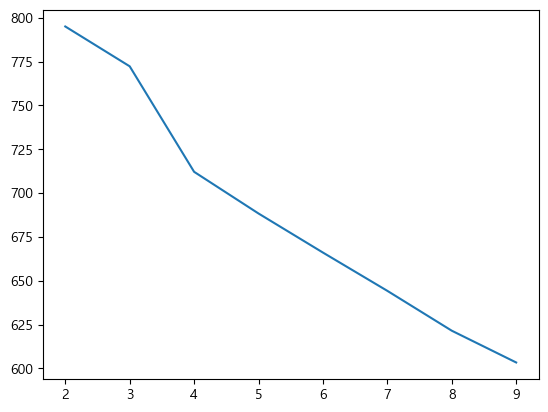

In [20]:
# 그룹수 튜닝
itr = []
for i in range(2,10):
    km = KMeans(n_clusters=i, n_init=5,random_state=42)
    km.fit(vector)
    itr.append(km.inertia_)
    
plt.plot(range(2,10), itr)
plt.show()   

In [21]:
# Kmeans : 클러스터 중심점과 가까운 데이터를 클러스터

# 첫번째 꺽임점 4를 우선 고려 다음 꺽임점 6를 두번째로 고려

model = KMeans(n_clusters=4, random_state=42, init='k-means++',max_iter=100, n_init=1)
model.fit(vector)

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=42)

In [22]:
# 그룹핑 결과를 데이터프레임에 적용
ddf['kmeans'] = model.labels_

In [23]:
ddf['kmeans'].value_counts()

2    559
0    173
1    165
3     92
Name: kmeans, dtype: int64

In [24]:
np.unique(model.labels_)

array([0, 1, 2, 3])

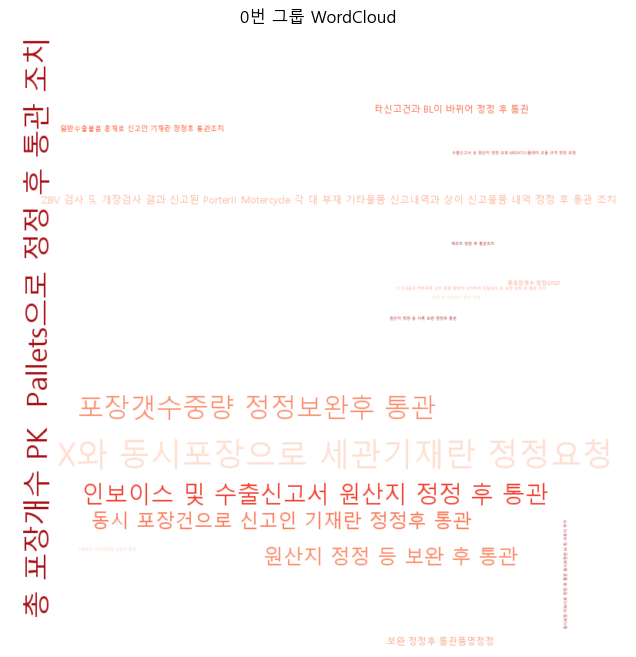

------------------------------------------------------------------------------------------


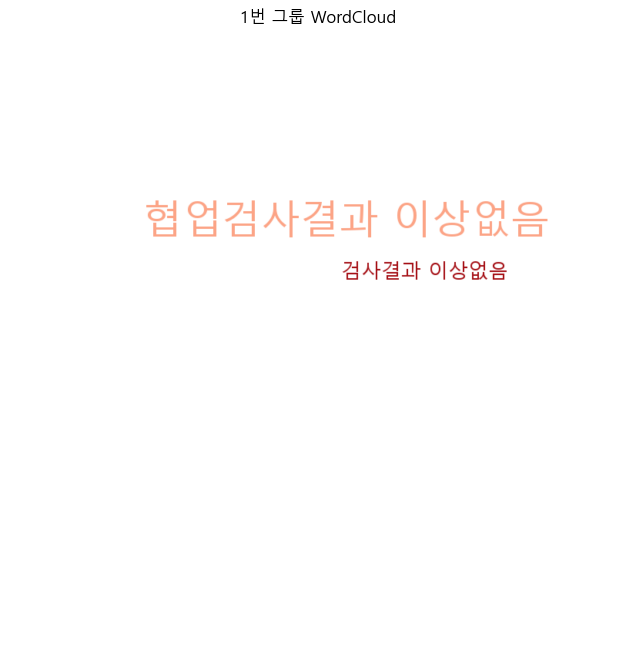

------------------------------------------------------------------------------------------


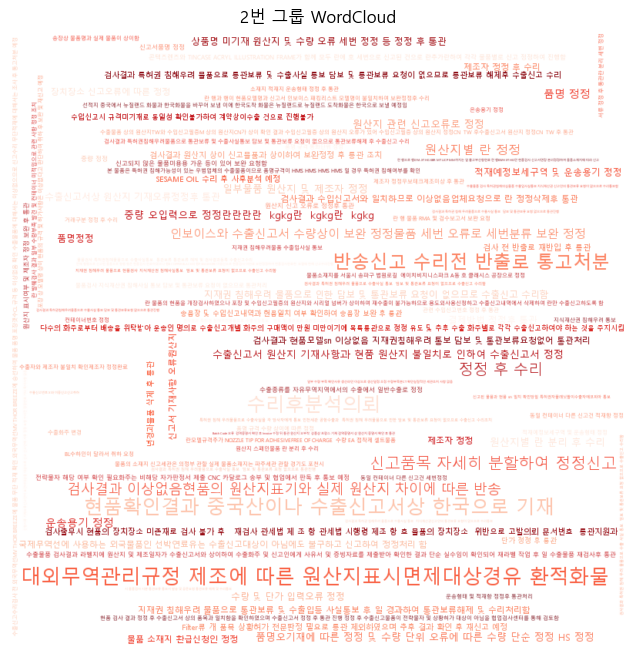

------------------------------------------------------------------------------------------


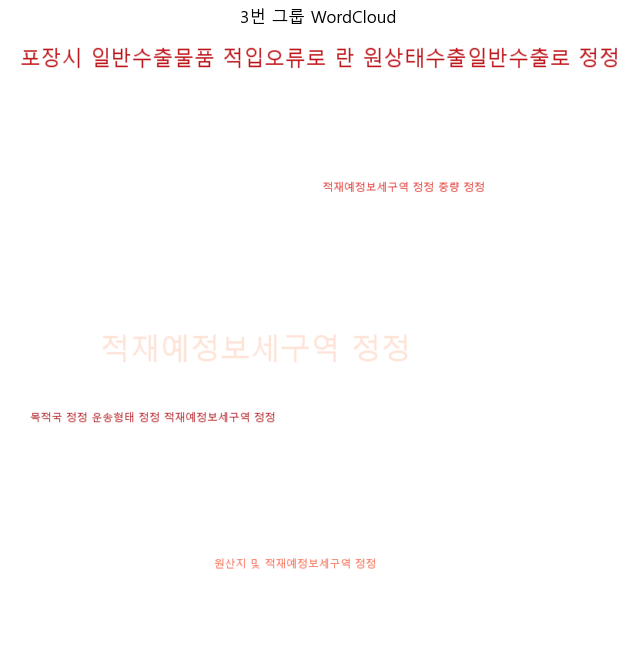

------------------------------------------------------------------------------------------


In [25]:
# 그룹별 워드클라우드 시각화
for i in range(ddf['kmeans'].max()+1):
    wordcloud(i,'kmeans')

### DBSCAN방식으로 비지도학습

In [26]:
# DBSCAN : 인접한 데이터를 클러스터링

vector = np.array(vector) # Normalizer를 이용해 변환된 벡터
# eps 그룹핑할 최대 반경거리
# min_samples 그룹핑한 반경안의 최소 샘플 갯수
model = DBSCAN(eps=0.6,min_samples=24)

# 거리 계산 식으로는 Cosine distance를 이용
model.fit(vector)
result = model.fit_predict(vector)

In [27]:
ddf['dbscan'] = result

In [28]:
np.unique(ddf['dbscan'])

array([-1,  0,  1,  2,  3,  4,  5], dtype=int64)

In [29]:
ddf['dbscan'].value_counts()

-1    650
 5    164
 0     61
 3     34
 1     30
 4     26
 2     24
Name: dbscan, dtype: int64

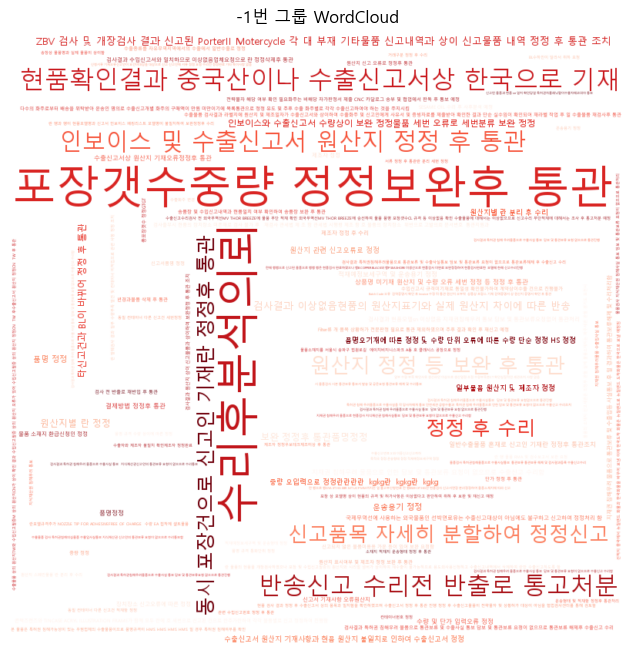

------------------------------------------------------------------------------------------


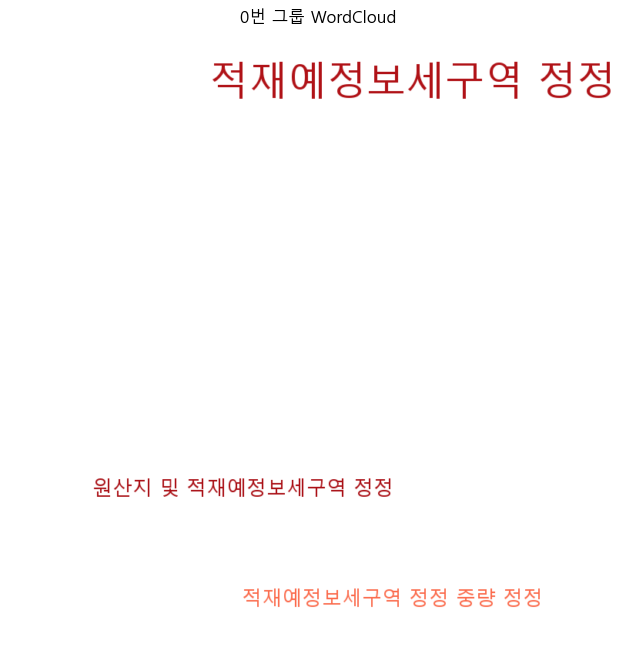

------------------------------------------------------------------------------------------


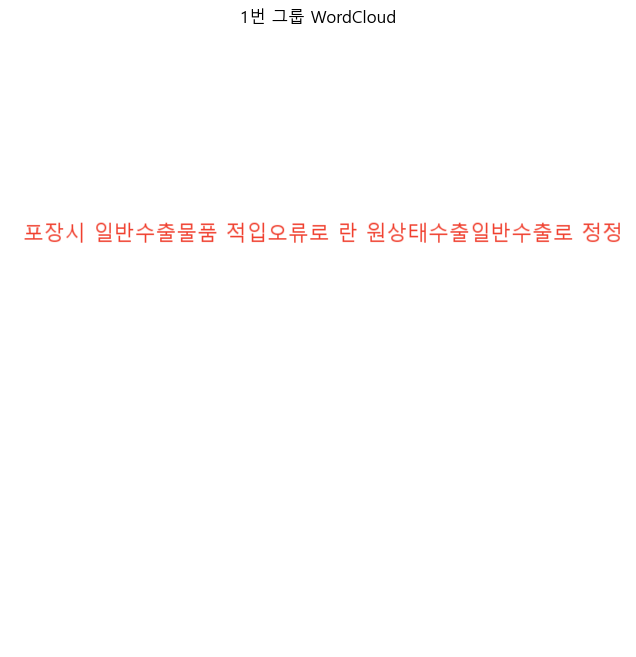

------------------------------------------------------------------------------------------


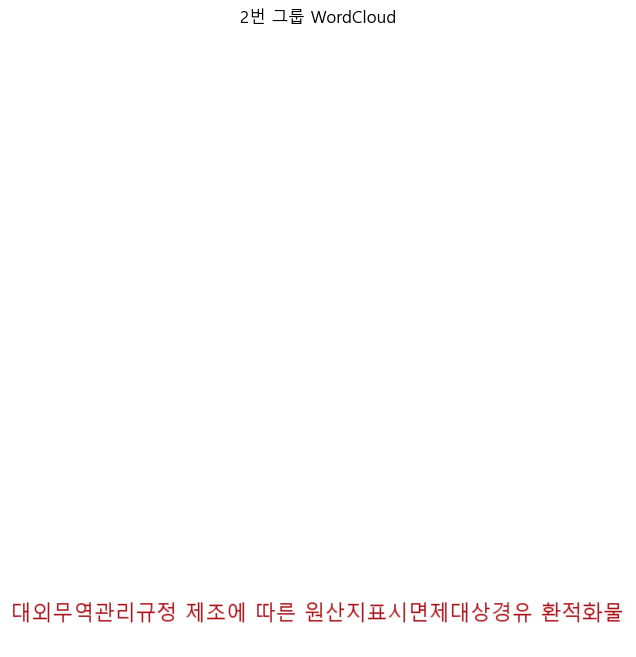

------------------------------------------------------------------------------------------


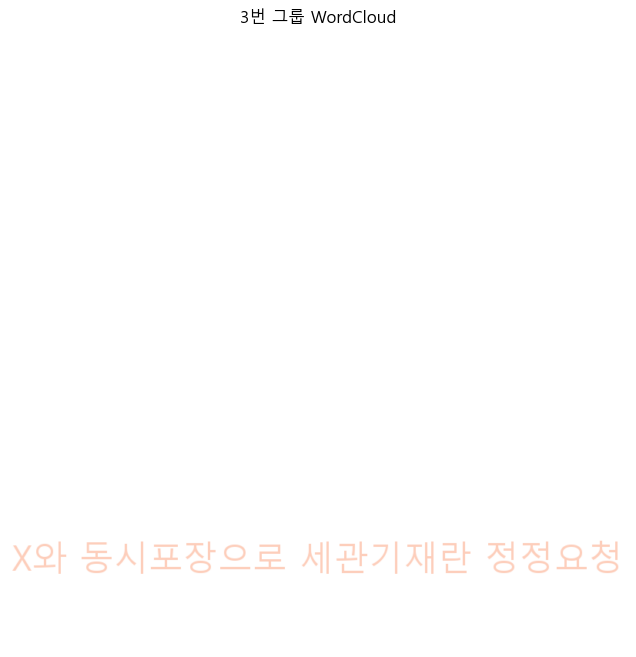

------------------------------------------------------------------------------------------


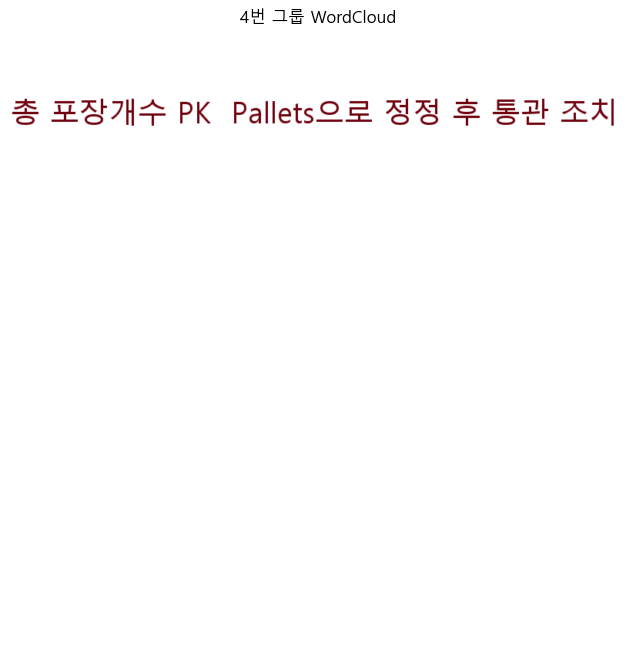

------------------------------------------------------------------------------------------


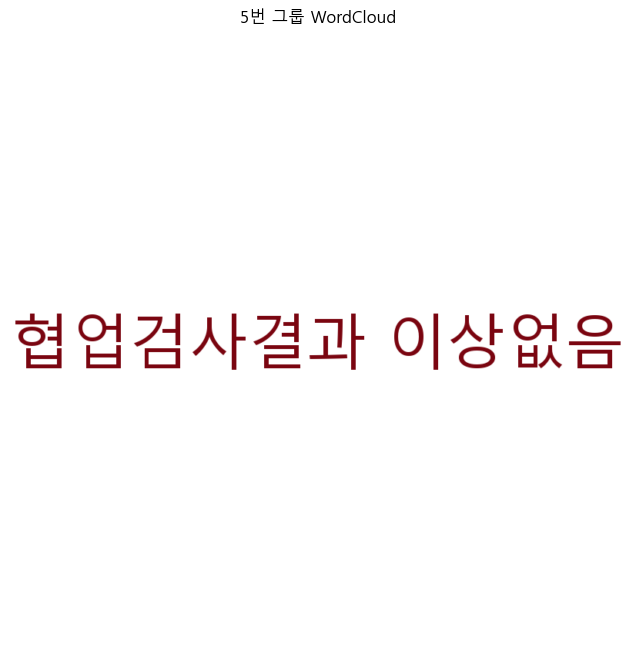

------------------------------------------------------------------------------------------


In [30]:
# 그룹별 워드클라우드 시각화
for i in range(-1, ddf['dbscan'].max()+1):
    wordcloud(i,'dbscan')

In [31]:
# ddf.to_csv('./ttt.csv',index=False,encoding='euc-kr')
ddf.to_excel('./수출신고지검사결과_비지도결과.xlsx',index=False,engine='openpyxl')